In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler

### load data and labels
### mfcc has various lengths 
import pandas as pd
import numpy as np

In [2]:
### load data and labels
### mfcc has various lengths 
import pandas as pd
import numpy as np

def segment_mfcc(mfcc, max_segment_length=200):
    # Segment the MFCC array into fixed lengths with possible overlap (if desired)
    # segment_length is the fixed length of each segment
    segments = []
    for start in range(0, mfcc.shape[1], max_segment_length):
        end = start + max_segment_length
        if end < mfcc.shape[1]:
            segments.append(mfcc[:, start:end])
        else:
            # Padding the last segment if it's shorter than the required segment length
            segments.append(np.pad(mfcc[:, start:], ((0,0), (0, max_segment_length - (mfcc.shape[1] - start))), 'constant'))
    return segments

def load_concatenated_mfcc(path):
    
    # Load the concatenated MFCC data
    data = np.load(path)
    return data['mfcc']

df = pd.read_csv('datasets/DAIC-WOZ/Patient_Classes.csv')

# for _, row in df.iterrows():
#     patient_id = row['Participant_ID']
#     label = row['PHQ8_Binary']
#     train_or_test = row['dataset'] # test or dev
#     mfcc_path = 'datasets/DAIC-WOZ/ConcatenatedMFCC/concatenated_mfcc_'+str(patient_id)+'.npz'
#     try:
#         mfcc = load_concatenated_mfcc(mfcc_path) # the raw mfcc data
#         # make a dataset to be able to train the CNN

#     except Exception as e:
#         print(e)
#         continue

def create_datasets(df, max_segment_length=500):
    dataset = {'train': [], 'test': []}
    labels = {'train': [], 'test': []}

    for _, row in df.iterrows():
        patient_id = row['Participant_ID']
        label = row['PHQ8_Binary']
        print(patient_id, label)
        train_or_test = row['dataset']  # Could be 'train' or 'test'
        # if train_or_test is 'dev' change it to 'test'
        if train_or_test == 'dev':
            train_or_test = 'test'

        mfcc_path = f'datasets/DAIC-WOZ/ConcatenatedMFCC/concatenated_mfcc_{patient_id}.npz'

        try:
            mfcc = load_concatenated_mfcc(mfcc_path)  # Load the raw MFCC data
            segments = segment_mfcc(mfcc, max_segment_length=max_segment_length)
            
            # Append each segment to the corresponding dataset
            for segment in segments:
                dataset[train_or_test].append(segment)
                labels[train_or_test].append(label)
        except Exception as e:
            print(f"Failed to process patient {patient_id}: {e}")

    return dataset, labels

In [3]:
def prepare_dataloaders(dataset, labels, batch_size=32):
    dataloaders = {}
    for phase in ['train', 'test']:
        features = torch.tensor(dataset[phase]).float()  # Convert features to float tensors
        targets = torch.tensor(labels[phase]).long()  # Convert labels to long tensors

        # Reshape for Conv1D: [batch, channels, length]
        features = features.permute(0, 1, 2)

        data_set = TensorDataset(features, targets)
        dataloaders[phase] = DataLoader(data_set, batch_size=batch_size, shuffle=(phase == 'train'))
    
    return dataloaders

SEQMENT_LENGTH = 100
# Assuming you have already loaded and segmented the data
dataset, labels = create_datasets(df, max_segment_length=SEQMENT_LENGTH) 
# dataloaders = prepare_dataloaders(dataset, labels)

303 0
304 0
305 0
310 0
312 0
313 0
315 0
316 0
317 0
318 0
319 1
320 1
321 1
322 0
324 0
325 1
326 0
327 0
328 0
330 1
333 0
336 0
338 1
339 1
340 0
341 0
343 0
344 1
345 1
347 1
348 1
350 1
351 1
352 1
353 1
355 1
356 1
357 0
358 0
360 0
362 1
363 0
364 0
366 0
368 0
369 0
370 0
371 0
372 1
374 0
375 0
376 1
379 0
380 1
383 0
385 0
386 1
391 0
392 0
393 0
397 0
400 0
401 0
402 1
409 0
412 1
414 1
415 0
416 0
419 0
423 0
425 0
426 1
427 0
428 0
429 0
430 0
433 1
434 0
437 0
441 1
443 0
444 0
445 0
446 0
447 0
448 1
449 0
454 0
455 0
456 0
457 0
459 1
463 0
464 0
468 0
471 0
473 0
474 0
475 0
478 0
479 0
485 0
486 0
487 0
488 0
491 0
Failed to process patient 491: [Errno 2] No such file or directory: 'datasets/DAIC-WOZ/ConcatenatedMFCC/concatenated_mfcc_491.npz'
302 0
307 0
331 0
335 1
346 1
367 1
377 1
381 1
382 0
388 1
389 1
390 0
395 0
403 0
404 0
406 0
413 1
417 0
418 1
420 0
422 1
436 0
439 0
440 1
451 0
458 0
472 0
476 0
477 0
482 0
483 1
484 0
489 0
Failed to process patient 489

In [4]:
class AudioDataset(Dataset):
    def __init__(self, mfcc_features, labels):
        self.features = torch.FloatTensor(mfcc_features)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [5]:
dataset_train = AudioDataset(dataset["train"], labels["test"])
dataset_val = AudioDataset(dataset["test"], labels["test"])

C:\Users\Gergo Gyori\AppData\Local\Temp\ipykernel_8100\587900977.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  self.features = torch.FloatTensor(mfcc_features)


### The model

In [ ]:
class TCC(nn.Module):
    def __init__(self, input_features=40, sequence_length=200):
        super(TCC, self).__init__()
        
        # Parallel CNN streams (as per paper Section 3.1)
        self.cnn_stream1 = CNNStream()
        self.cnn_stream2 = CNNStream()
        
        # Transformer stream with linear attention
        self.transformer_stream = TransformerStream(input_features, sequence_length)
        
        # Fusion layer
        cnn_out_size = 64 * (sequence_length // 8)  # After 3 max pooling layers
        transformer_out_size = 512


        # total_features = (cnn_out_size * 2) + transformer_out_size
        total_features = (cnn_out_size * 2) + 128  # reduced from 512

        
        self.fusion = nn.Sequential(
            nn.Linear(total_features, 128), #reduce the number of features 512 was
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2)  # Binary classification # reduced from 512, 256, 128
        )

    def forward(self, x):
        # Parallel processing through streams
        cnn1_out = self.cnn_stream1(x)
        cnn2_out = self.cnn_stream2(x)
        transformer_out = self.transformer_stream(x)
        
        # Flatten and concatenate
        cnn1_out = cnn1_out.flatten(1)
        cnn2_out = cnn2_out.flatten(1)
        
        # Fusion
        combined = torch.cat([cnn1_out, cnn2_out, transformer_out], dim=1)
        output = self.fusion(combined)
        
        return output

class CNNStream(nn.Module):
    def __init__(self):
        super(CNNStream, self).__init__()
        
        # Three conv layers as specified in paper
        self.layers = nn.Sequential(
            # First conv block
            nn.Conv1d(40, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(16),
            nn.Dropout(0.3),
            
            # Second conv block
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            
            # Third conv block
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        
    def forward(self, x):
        return self.layers(x)

class TransformerStream(nn.Module):
    def __init__(self, input_features, sequence_length):
        super(TransformerStream, self).__init__()
        
        self.input_proj = nn.Linear(input_features, 128) # 265 instead of 512
        
        # Four transformer layers with linear attention
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d_model=128) for _ in range(2) # reduced to 256 from 512 range 4-> 2
        ])
        
        # Output pooling
        self.pool = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, x):
        # Transform input: [batch, features, seq] -> [batch, seq, features]
        x = x.transpose(1, 2)
        
        # Project to transformer dimension
        x = self.input_proj(x)
        
        # Apply transformer layers
        for layer in self.transformer_layers:
            x = layer(x)
        
        # Global pooling over sequence dimension
        x = x.transpose(1, 2)  # [batch, features, seq]
        x = self.pool(x).squeeze(-1)  # [batch, features]
        
        return x

class TransformerLayer(nn.Module):
    def __init__(self, d_model=512):
        super(TransformerLayer, self).__init__()
        
        # Linear attention with 4 heads
        self.attention = LinearAttention(d_model, n_heads=4)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 2048),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2048, d_model)
        )
        
        # Layer norms
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
    def forward(self, x):
        # Multi-head attention with residual
        attended = self.attention(x)
        x = self.norm1(x + attended)
        
        # Feed-forward with residual
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x

class LinearAttention(nn.Module):
    def __init__(self, d_model, n_heads=4):
        super(LinearAttention, self).__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        
        # Linear projections
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)
        
        self.elu = nn.ELU()
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Linear projections and reshape to heads
        q = self.q_proj(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        k = self.k_proj(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        v = self.v_proj(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        
        # Apply ELU + 1 for positive values (as per paper)
        q = self.elu(q) + 1
        k = self.elu(k) + 1
        
        # Linear attention computation
        k_cumsum = k.sum(dim=1, keepdim=True)
        D_inv = 1.0 / torch.einsum('bhnd,bhnd->bhn', q, k_cumsum)
        context = torch.einsum('bhnd,bhne->bhde', k, v)
        out = torch.einsum('bhnd,bhde,bhn->bhne', q, context, D_inv)
        
        # Reshape and project output
        out = out.contiguous().view(batch_size, seq_len, self.d_model)
        out = self.o_proj(out)
        
        return out

def train_model(model, train_loader, val_loader, num_epochs=200, learning_rate=0.001, global_history=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    best_val_acc = 0
    patience = 20
    patience_counter = 0

        # Initialize metric collectors
    global_history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        # Calculate metrics
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        global_history['train_loss'].append(avg_train_loss*100)
        global_history['val_loss'].append(avg_val_loss*100)
        global_history['train_acc'].append(train_acc)
        global_history['val_acc'].append(val_acc)

        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        # validation loss aand accuracy print
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%\n')
        print(40 * '-')
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                # break
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%\n')
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, history

### Train

In [48]:
BATCH_SIZE = 64

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE)

# set for reduced memory usage


# torch.set_default_tensor_type(torch.cuda.FloatTensor)

global_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


model = TCC(input_features=40, sequence_length=SEQMENT_LENGTH) 
model, history = train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, global_history=global_history)

Using device: cuda
Epoch 1/10
Train Loss: 0.5612, Train Acc: 70.62%
Val Loss: 0.8520, Val Acc: 55.66%

----------------------------------------
Epoch 2/10
Train Loss: 0.4639, Train Acc: 76.17%
Val Loss: 0.9498, Val Acc: 53.56%

----------------------------------------
Epoch 3/10
Train Loss: 0.4405, Train Acc: 77.70%
Val Loss: 1.4964, Val Acc: 51.58%

----------------------------------------
Epoch 4/10
Train Loss: 0.4245, Train Acc: 79.21%
Val Loss: 1.0401, Val Acc: 54.17%

----------------------------------------
Epoch 5/10
Train Loss: 0.4234, Train Acc: 78.97%
Val Loss: 1.2335, Val Acc: 51.77%

----------------------------------------
Epoch 6/10
Train Loss: 0.4166, Train Acc: 79.22%
Val Loss: 1.4132, Val Acc: 54.42%

----------------------------------------
Epoch 7/10
Train Loss: 0.4140, Train Acc: 79.51%
Val Loss: 1.1106, Val Acc: 50.25%

----------------------------------------
Epoch 8/10
Train Loss: 0.4081, Train Acc: 80.20%
Val Loss: 1.3318, Val Acc: 51.99%

----------------------

In [110]:
global_history

{'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

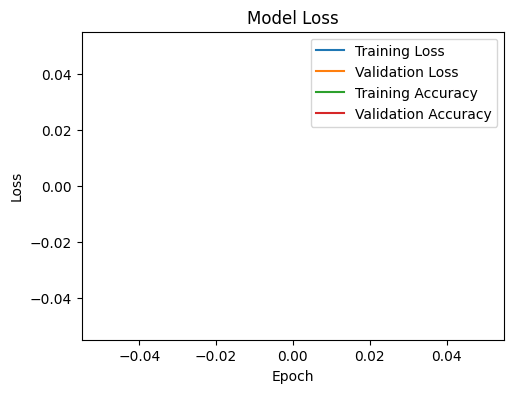

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(global_history['train_loss'], label='Training Loss')
# train loss each value is duplicated by 100

plt.plot(global_history['val_loss'], label='Validation Loss')
plt.plot(global_history['train_acc'], label='Training Accuracy')
plt.plot(global_history['val_acc'], label='Validation Accuracy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
